In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
from os import listdir
from os.path import isfile, join
import io
import time

import glob

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

Using TensorFlow backend.


In [ ]:
# Check if any duplicates are in the dataset 

In [62]:
# load data function
IMG_DIM = (150, 150)

dataset_path = os.getcwd()

def apply_permutation(data, indexes):
    n = len(data)
    result = np.empty(n, dtype=object)
    for i in range(n):
        result[i] = data[indexes[i]]
    return result

def load_dataset(data_type):
    path = join(dataset_path, data_type)
    files = []
    labels = []
    f_dir = [f for f in listdir(path) if not isfile(join(path, f))]

    for directory in f_dir:
        new_files = [join(path, directory, f) for f in listdir(join(path, directory)) if isfile(join(path, directory, f))]
        files.extend(new_files)
        for f in new_files:
            labels.append(directory)

    # shuffling data
    print(len(files), len(labels))
    shuffled_indices = np.random.permutation(len(files))
    files = apply_permutation(files, shuffled_indices)
    labels = apply_permutation(labels, shuffled_indices)
    imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in files]
    imgs = np.array(imgs)

    return imgs, labels


In [63]:
imgs, labels = load_dataset('train')

train_imgs = imgs
train_labels = labels

validation_path = load_dataset('valid')
validation_imgs = imgs
validation_labels = labels

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)


23657 23657
875 875
Train dataset shape: (23657, 150, 150, 3) 	Validation dataset shape: (23657, 150, 150, 3)


(150, 150, 3)


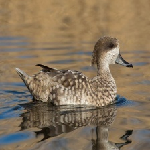

In [68]:
max_instances = 3000
train_imgs_scaled = train_imgs[:max_instances].astype('float32')
validation_imgs_scaled  = validation_imgs[:max_instances].astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[0].shape)
array_to_img(train_imgs[0])

In [69]:
batch_size = 30
num_classes = 175
epochs = 30
input_shape = (150, 150, 3)

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[1495:1505], train_labels_enc[1495:1505])

['RED WINGED BLACKBIRD' 'MOURNING DOVE' 'PAINTED BUNTIG' 'ARARIPE MANAKIN'
 'RED THROATED BEE EATER' 'TRUMPTER SWAN' 'BELTED KINGFISHER'
 'BAY-BREASTED WARBLER' 'TIT MOUSE' 'TURKEY VULTURE'] [137 107 120  11 136 162  19  18 160 163]
